In [59]:
from scipy.sparse import hstack, csr_matrix
from tqdm import tqdm
import numpy as np
import pandas as pd
import re

from collections import Counter
from collections import defaultdict
from scipy import sparse
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

sns.set_style("whitegrid")

# Part 1: Representing Text Data

In [60]:
df_train = pd.read_csv("data/train.csv")
df_dev = pd.read_csv("data/dev.csv")
df_test = pd.read_csv("data/test.csv")

## Part 1.1: Tokenization

In [61]:
stop_words = {
    'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 
    'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
    'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 
    'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 
    'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 
    'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 
    'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 
    'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 
    'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 
    'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 
    'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
    'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 
    'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than',
    '<h>', '</h>'
}

stop_punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—'''

In [62]:
def tokenize(text):
    # Split the text by whitespace and return the list of tokens
    return text.split()

def better_tokenize(input_str, punctuations=stop_punctuations, stopwords=stop_words):
    # Remove line breaks and filter out <> enclosed text
    cleaned_str = re.sub(r'\n|\<[^<>]*\>', '', input_str)

    # Remove punctuations
    for punctuation in punctuations:
        cleaned_str = cleaned_str.replace(punctuation, '')

    # Convert to lowercase and split into words
    words = cleaned_str.lower().split()

    # Filter out stopwords
    filtered_words = filter(lambda word: word not in stopwords, words)

    return list(filtered_words)

In [63]:
input_str = "Your sample text goes here."
tokens = better_tokenize(input_str)
print(tokens)

['sample', 'text', 'goes']


## Part 1.2: Building the Term-Document Matrix

In [64]:
def build_term_freq_dict(dataframe, text_col, min_freq=2, tokenize_function=better_tokenize):
    term_counter = Counter()

    # Iterate through each document and update term frequencies
    for document in dataframe[text_col]:
        terms = tokenize_function(document)
        term_counter.update(terms)

    # Retain terms that meet the minimum frequency threshold
    filtered_terms = {term: freq for term, freq in term_counter.items() if freq >= min_freq}

    return filtered_terms

# Example usage
term_dictionary = build_term_freq_dict(df_train, 'text', 10)

In [65]:
def createCompressedSparseRowMatrix(documents, vocab={}, frequencyFilter=term_dictionary):
    rowStart = [0]
    colIndices = []
    values = []

    print("Constructing compressed sparse row (CSR) matrix...")
    for document in tqdm(documents):
        for word in document:
            if word in frequencyFilter:  # Exclude terms with low frequency
                wordIndex = vocab[word] if word in vocab else len(vocab)
                vocab[word] = wordIndex
                colIndices.append(wordIndex)
                values.append(1)
        rowStart.append(len(colIndices))

    csrMatrix = sparse.csr_matrix((values, colIndices, rowStart), dtype=int)
    return csrMatrix, vocab

In [66]:
def createCompressedSparseRowMatrix(documents, vocab=None, frequencyFilter=term_dictionary):
    rowStart = [0]
    colIndices = []
    values = []
    new_vocab = {}
    if vocab is None:
        print("Constructing compressed sparse row (CSR) matrix...")
        for document in tqdm(documents):
            for word in document:
                if word in frequencyFilter:  # Exclude terms with low frequency
                    wordIndex = new_vocab[word] if word in new_vocab else len(new_vocab)
                    new_vocab[word] = wordIndex
                    colIndices.append(wordIndex)
                    values.append(1)
            rowStart.append(len(colIndices))

        csrMatrix = sparse.csr_matrix((values, colIndices, rowStart), dtype=int)
    else:
        new_vocab = vocab.copy()
        print("Constructing compressed sparse row (CSR) matrix...")
        for document in tqdm(documents):
            for word in document:
                if word in frequencyFilter and word in new_vocab:  # 仅处理存在于词汇表中的单词
                    wordIndex = new_vocab[word]
                    colIndices.append(wordIndex)
                    values.append(1)
            rowStart.append(len(colIndices))
            
        csrMatrix = sparse.csr_matrix((values, colIndices, rowStart), shape=(len(documents), len(new_vocab)), dtype=int)
    return csrMatrix, new_vocab

In [67]:
# Prepare the document list
document_list = []
print("Creating document list for training...")
for idx, record in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    document_list.append(better_tokenize(record["text"]))

# Generate the CSR matrix
training_matrix, training_vocab = createCompressedSparseRowMatrix(document_list, vocab=None, frequencyFilter=term_dictionary)

# Add a bias column to the matrix
bias_column = np.ones((training_matrix.shape[0], 1))
training_matrix_with_bias = sparse.hstack([training_matrix, bias_column]).tocsr()

Creating document list for training...


100%|██████████| 7328/7328 [00:00<00:00, 16919.41it/s]


Constructing compressed sparse row (CSR) matrix...


100%|██████████| 7328/7328 [00:00<00:00, 203547.39it/s]


# Part 2: Logistic Regression in numpy

In [68]:
def sigmoid(X):
    # Using np.exp for element-wise exponential
    return np.divide(1, np.add(1, np.exp(np.negative(X))))

def log_likelihood(X, y, beta):
    sum = 0
    for i in range(X.shape[0]):  # 遍历样本
        x_i = X[i].toarray().flatten()
        sum += y[i] * np.dot(beta, x_i) - np.log10(1 + np.exp(np.dot(beta, x_i)))
    return sum

def compute_gradient(x, y, beta):
    # Using np.subtract and np.outer for vectorized operations
    prediction_error = np.subtract(sigmoid(np.dot(beta, x)), y)
    gradient = np.multiply(prediction_error, x)
    return gradient

In [69]:
def logistic_regression(X, y, learning_rate=5e-5, num_step=1000, is_plot=False):
    # Initialize variables
    vocab_size = X.shape[1]  # Size of the vocabulary
    beta_params = np.zeros(vocab_size)  # Initializing beta parameters
    prev_log_likelihood = log_likelihood(X, y, beta_params)  # Initial log-likelihood

    # Initialize plot-related lists if plotting is enabled
    steps, log_likelihoods = ([], []) if is_plot else (None, None)

    print("Running Logistic Regression...")
    for step in tqdm(range(num_step)):
        # Update beta using a gradient step
        current_index = step % vocab_size
        X_sample = X[current_index].toarray().ravel()
        y_sample = y[current_index]
        gradient = compute_gradient(X_sample, y_sample, beta_params)
        beta_params -= learning_rate * gradient

        # Record log-likelihood and step count at every 100th step
        if is_plot and step % 100 == 0:
            steps.append(step)
            log_likelihoods.append(log_likelihood(X, y, beta_params))

    # Return results based on whether plotting is enabled
    return (beta_params, steps, log_likelihoods) if is_plot else beta_params

In [70]:
def predict(text, model_coefficients, vocabulary=training_vocab):
    feature_vector = np.zeros(len(vocabulary) + 1)
    
    word_counts = Counter(better_tokenize(text))
    for word, count in word_counts.items():
        if word in vocabulary:
            feature_vector[vocabulary[word]] = count
    feature_vector[-1] = 1  # Add bias term

    prediction = sigmoid(np.dot(model_coefficients, feature_vector))
    return int(prediction >= 0.152)

## Part 2.1: Plot log-likelihood

In [71]:
# Mapping labels
label_map = {0: 0, 1: 1}
train_labels = np.array([label_map[label] for label in df_train['label']])

# Perform logistic regression
regression_beta, iteration_steps, log_likelihoods = logistic_regression(
    X=training_matrix_with_bias,
    y=train_labels,
    num_step=10000,
    is_plot=True
)

Running Logistic Regression...


100%|██████████| 10000/10000 [00:44<00:00, 226.27it/s]


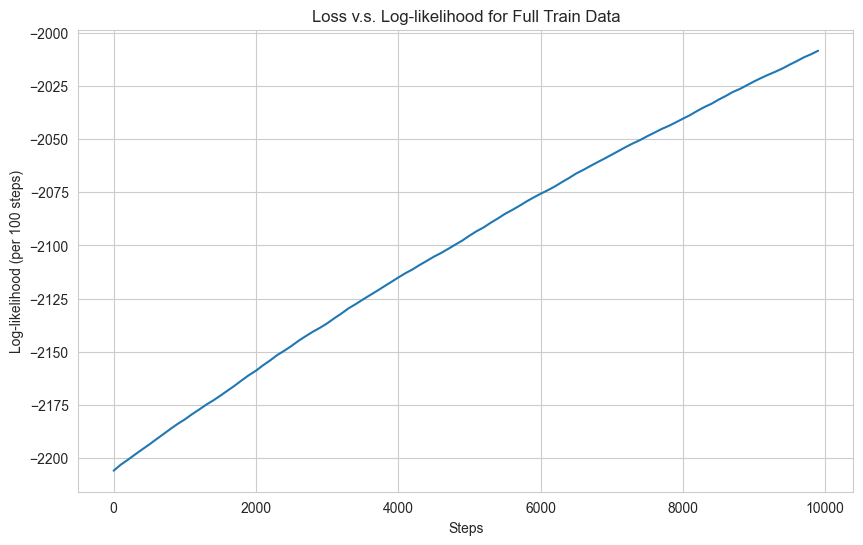

In [72]:
# Plotting the relationship between steps and log-likelihood
fig, plot_axis = plt.subplots(figsize=(10, 6))
sns.lineplot(x=iteration_steps, y=log_likelihoods, ax=plot_axis)
plot_axis.set_xlabel("Steps")
plot_axis.set_ylabel("Log-likelihood (per 100 steps)")
plot_axis.set_title("Loss v.s. Log-likelihood for Full Train Data")
plt.show()

## Part 2.2: Make prediction on validation dataset

In [73]:
# train the beta
beta = logistic_regression(X = training_matrix_with_bias,
                           y = train_labels, 
                           learning_rate = 5e-5, 
                           num_step = 500000)

Running Logistic Regression...


100%|██████████| 500000/500000 [00:32<00:00, 15253.70it/s]


In [74]:
# make prediction
y_test = [label_map[p] for p in df_dev["label"]]
y_pred = []
print("Starting prediction on validation dataset...")
for i in tqdm(range(len(df_dev))):
    y_pred.append(predict(df_dev["text"][i], beta))

Starting prediction on validation dataset...


100%|██████████| 1047/1047 [00:00<00:00, 24057.13it/s]


In [75]:
f1_score(y_test, y_pred)

0.3626373626373627

## Part 2.3: Make prediction on test dataset

In [76]:
label_reverse_map = {0: 0, 1: 1}

# Function to predict labels
def make_predictions(data):
    predictions = []
    print("Predicting labels for test dataset...")
    for index, row in tqdm(data.iterrows(), total=len(data)):
        text_content = str(row['text'])
        predictions.append(predict(text_content, beta))
    return predictions

# Generate predictions
predicted_labels = make_predictions(df_test)

# Create result dataframe and save to CSV
result_df = pd.DataFrame({
    'par_id': df_test['par_id'],
    'label': [label_reverse_map[label] for label in predicted_labels]
})
result_df.to_csv("part2_result.csv", index=False)

Predicting labels for test dataset...


100%|██████████| 2094/2094 [00:00<00:00, 12162.52it/s]


# Part 3: Logistic Regression in PyTorch

In [77]:
def to_sparse_tensor(sparse_matrix: csr_matrix):
    sparse_matrix = sparse_matrix.tocoo()  # 将矩阵转换为COO格式
    indices = np.vstack((sparse_matrix.row, sparse_matrix.col))  # 获取坐标
    indices = torch.LongTensor(indices)  # 将坐标转换为torch张量
    values = torch.FloatTensor(sparse_matrix.data)  # 将值转换为torch张量
    shape = torch.Size(sparse_matrix.shape)  # 获取矩阵的形状
    return torch.sparse.FloatTensor(indices, values, shape)

In [78]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, input_features):
        super(LogisticRegressionPyTorch, self).__init__()
        self.linear = nn.Linear(input_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [79]:
dev_labels = np.array([label_map[label] for label in df_dev['label']])
# Prepare the document list
document_list = []
print("Creating document list for dev...")
for idx, record in tqdm(df_dev.iterrows(), total=df_dev.shape[0]):
    document_list.append(better_tokenize(record["text"]))

# Generate the CSR matrix
dev_matrix, dev_vocab = createCompressedSparseRowMatrix(document_list, vocab=training_vocab, frequencyFilter=term_dictionary)

# Add a bias column to the matrix
bias_column = np.ones((dev_matrix.shape[0], 1))
dev_matrix_with_bias = sparse.hstack([dev_matrix, bias_column]).tocsr()

# 使用to_sparse_tensor函数将稀疏矩阵转换为PyTorch的稀疏张量
X_train = to_sparse_tensor(training_matrix_with_bias)
X_dev = to_sparse_tensor(dev_matrix_with_bias)

# 接下来，将标签也转换为张量
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels, dtype=torch.float32).unsqueeze(1)

Creating document list for dev...


100%|██████████| 1047/1047 [00:00<00:00, 19003.06it/s]


Constructing compressed sparse row (CSR) matrix...


100%|██████████| 1047/1047 [00:00<00:00, 258532.69it/s]


In [80]:
def plot_metrics(losses, f1_scores, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(f1_scores, label='F1 Score')
    plt.title(f'{title} - F1 Score')
    plt.xlabel('Steps')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()

## Part 3.1: 1000 steps training and reporting losses every 20 steps

Step 0, Loss: 0.6987284421920776, F1 Score: 0.1325
Step 20, Loss: 0.43701404333114624, F1 Score: 0.0000
Step 40, Loss: 0.35366329550743103, F1 Score: 0.0000
Step 60, Loss: 0.44173136353492737, F1 Score: 0.0000
Step 80, Loss: 0.3737538754940033, F1 Score: 0.0000
Step 100, Loss: 0.24392330646514893, F1 Score: 0.0000
Step 120, Loss: 0.1487138867378235, F1 Score: 0.0000
Step 140, Loss: 0.40534451603889465, F1 Score: 0.0000
Step 160, Loss: 0.3553345203399658, F1 Score: 0.0000
Step 180, Loss: 0.29317623376846313, F1 Score: 0.0000
Step 200, Loss: 0.39221110939979553, F1 Score: 0.0000
Step 220, Loss: 0.2600035071372986, F1 Score: 0.0000
Step 240, Loss: 0.13141249120235443, F1 Score: 0.0000
Step 260, Loss: 0.23649157583713531, F1 Score: 0.0000
Step 280, Loss: 0.3240104913711548, F1 Score: 0.0000
Step 300, Loss: 0.28223249316215515, F1 Score: 0.0000
Step 320, Loss: 0.2630406618118286, F1 Score: 0.0000
Step 340, Loss: 0.2923699915409088, F1 Score: 0.0000
Step 360, Loss: 0.3167116940021515, F1 Sco

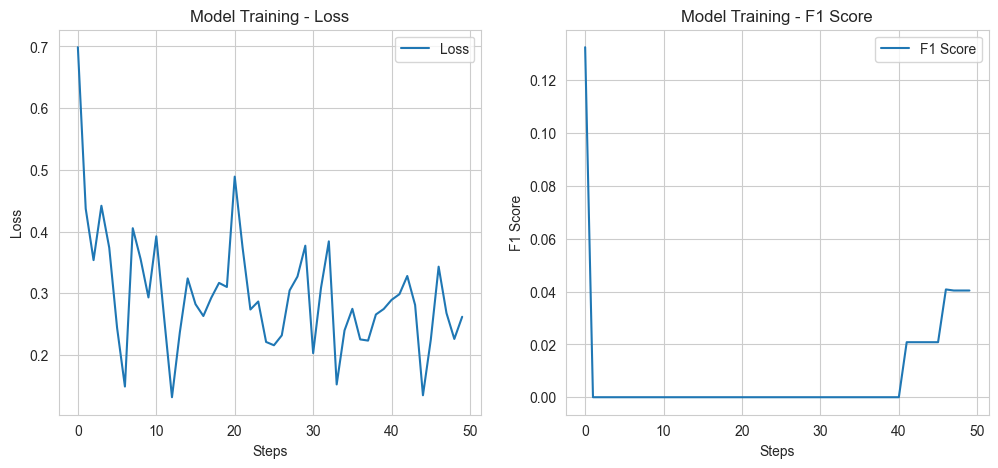

In [81]:
# 创建TensorDataset和DataLoader以进行批处理
dataset = TensorDataset(X_train, y_train)
batch_size = 64  # 或者您选择的其他批次大小
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
model = LogisticRegressionPyTorch(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def train_model_1000_steps(model, dataloader, criterion, optimizer, X_dev, y_dev, total_steps=1000, report_interval=20):
    model.train()
    step = 0
    losses = []
    f1_scores = []

    while step < total_steps:
        for inputs, labels in dataloader:
            if step >= total_steps:
                break
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % report_interval == 0:
                losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    dev_outputs = model(X_dev).squeeze()
                    dev_predictions = (dev_outputs >= 0.5).float()
                    f1 = f1_score(y_dev.numpy(), dev_predictions.numpy())
                    f1_scores.append(f1)
                model.train()
                print(f'Step {step}, Loss: {loss.item()}, F1 Score: {f1:.4f}')
            
            step += 1

    return losses, f1_scores

losses, f1_scores = train_model_1000_steps(model, dataloader, criterion, optimizer, X_dev, y_dev)
plot_metrics(losses, f1_scores, "Model Training")

## Part 3.2: Train at least 1 epoch and calculate the loss and F1 score

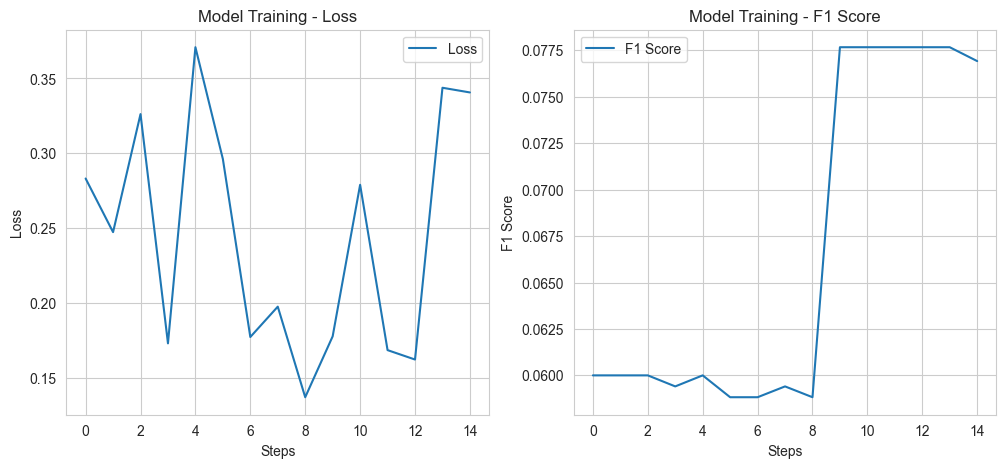

In [82]:
def train_model_n_epoch(model, dataloader, criterion, optimizer, num_epochs=5, report_interval=50):
    losses = []
    f1_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        step = 0
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % report_interval == 0:
                losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    dev_outputs = model(X_dev).squeeze()
                    dev_predictions = (dev_outputs >= 0.5).float()
                    f1 = f1_score(y_dev.numpy(), dev_predictions.numpy())
                    f1_scores.append(f1)
                model.train()

            step += 1

    return losses, f1_scores

# 调用函数训练模型
losses, f1_scores = train_model_n_epoch(model, dataloader, criterion, optimizer)
plot_metrics(losses, f1_scores, "Model Training")

## Part 3.3：Add regularization (L2 penalty)

Training with L2 penalty = 0


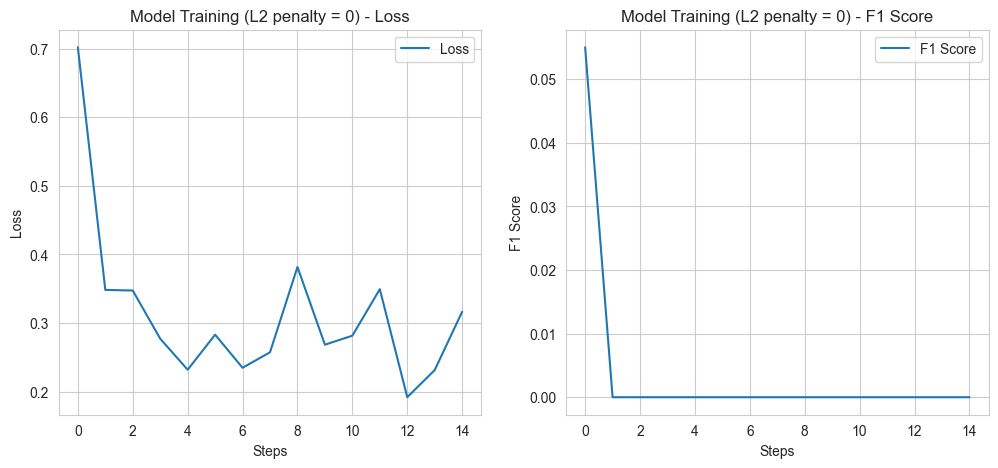

Training with L2 penalty = 0.001


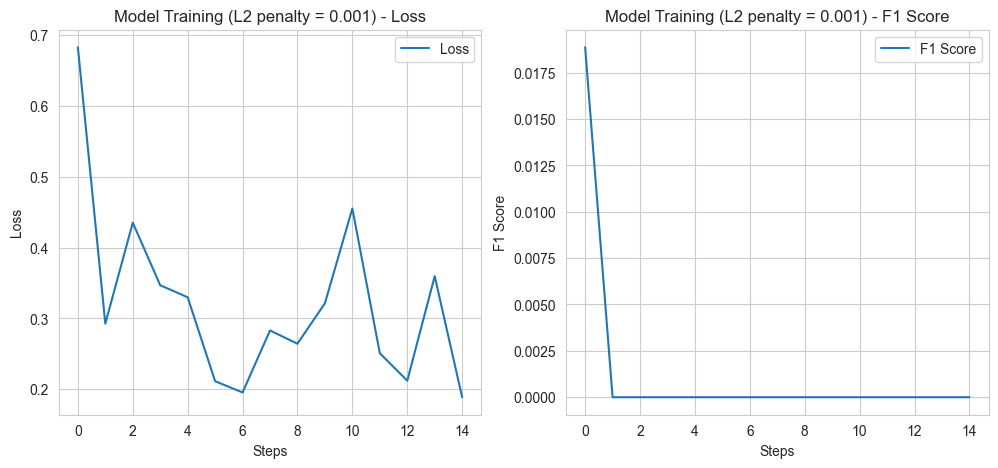

Training with L2 penalty = 0.1


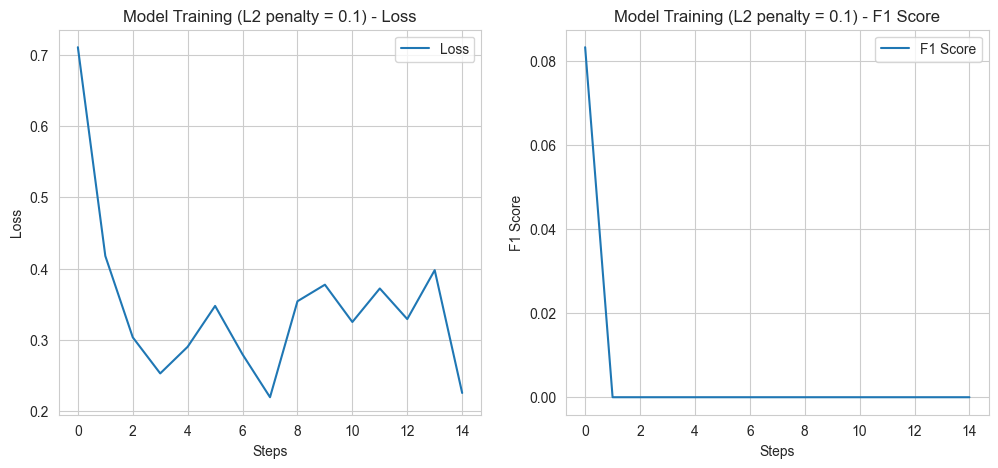

In [83]:
l2_values = [0, 0.001, 0.1]
for l2 in l2_values:
    model = LogisticRegressionPyTorch(X_train.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=l2)
    print(f"Training with L2 penalty = {l2}")
    losses, f1_scores = train_model_n_epoch(model, dataloader, criterion, optimizer)
    plot_metrics(losses, f1_scores, f"Model Training (L2 penalty = {l2})")

## Part 3.4: Use different optimizers

Training with optimizer RMSprop


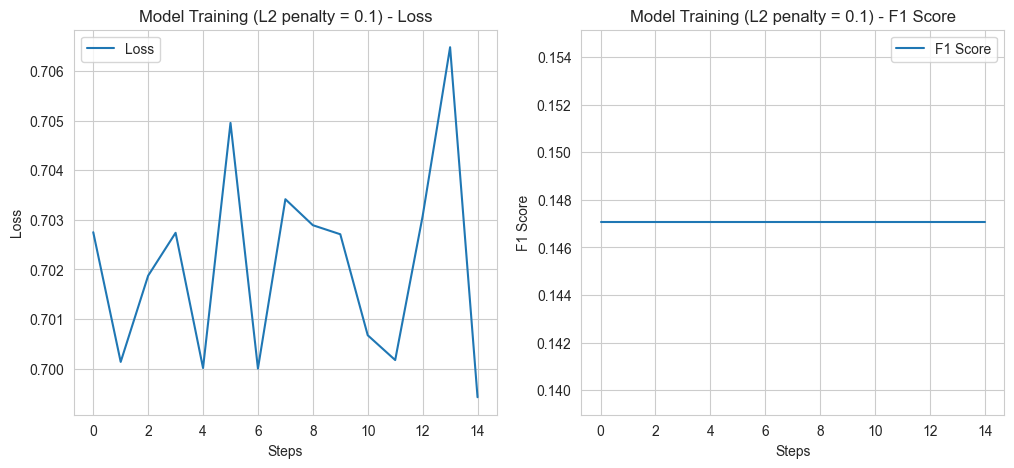

Training with optimizer AdamW


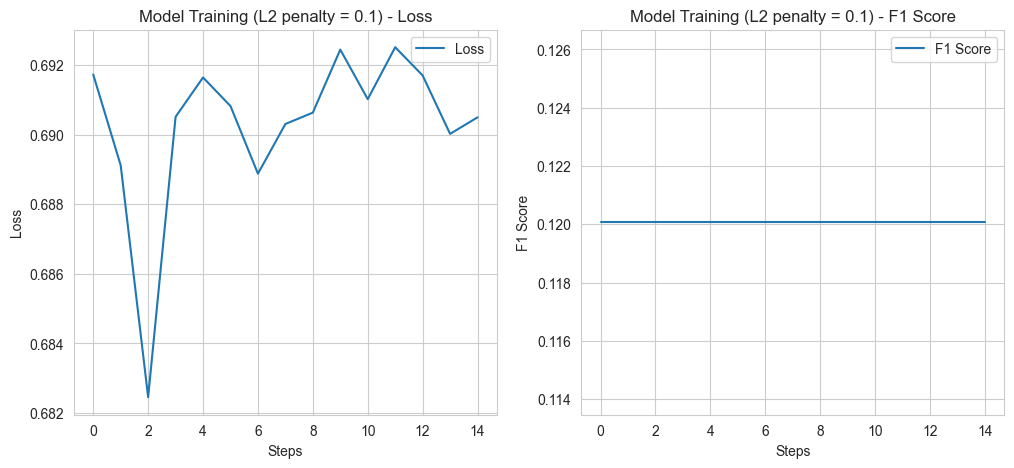

In [84]:
optimizers = {
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.01),
    'AdamW': optim.AdamW(model.parameters(), lr=0.01)
}

for opt_name, optimizer in optimizers.items():
    model = LogisticRegressionPyTorch(X_train.shape[1])
    print(f"Training with optimizer {opt_name}")
    losses, f1_scores = train_model_n_epoch(model, dataloader, criterion, optimizer)
    plot_metrics(losses, f1_scores, f"Model Training (L2 penalty = {l2})")

## Part 3.5: Comparison of different word segmentation methods

Creating document list for training with simple_tokenize...


100%|██████████| 7328/7328 [00:00<00:00, 18439.70it/s]


Constructing compressed sparse row (CSR) matrix...


100%|██████████| 7328/7328 [00:00<00:00, 178732.19it/s]


Epoch 0, Step 0, Loss: 0.6929141283035278, F1 Score: 0.1201
Epoch 0, Step 50, Loss: 0.6895198225975037, F1 Score: 0.1201
Epoch 0, Step 100, Loss: 0.6929212808609009, F1 Score: 0.1201


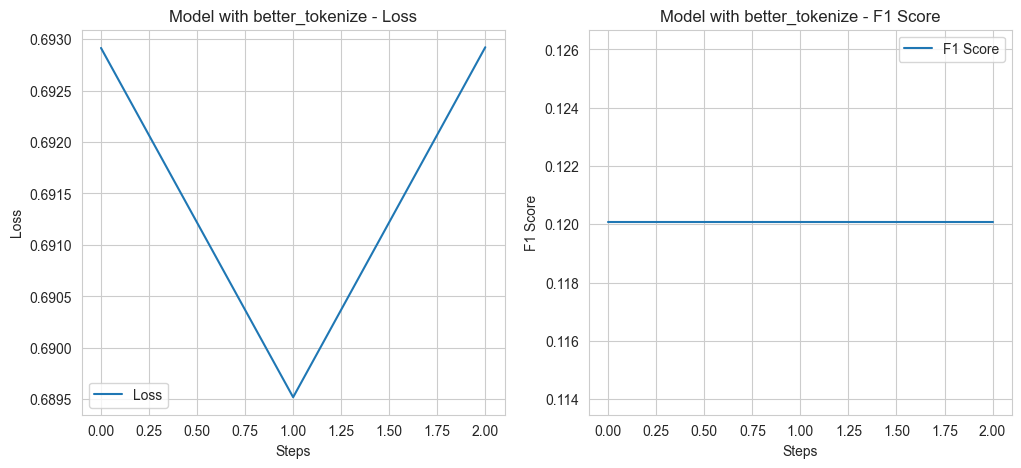

Epoch 0, Step 0, Loss: 0.6891342997550964, F1 Score: 0.0000
Epoch 0, Step 50, Loss: 0.29859521985054016, F1 Score: 0.0000
Epoch 0, Step 100, Loss: 0.309869647026062, F1 Score: 0.0000


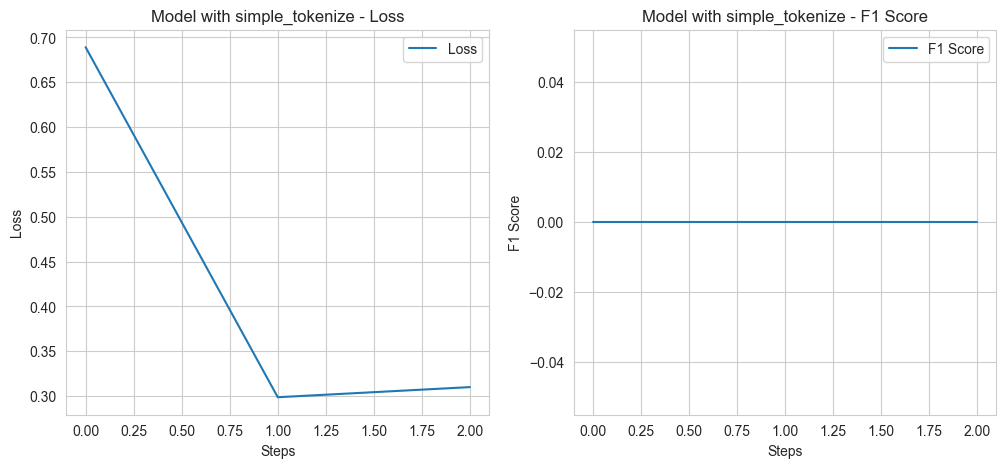

In [85]:
def simple_tokenize(input_str):
    # Convert to lowercase and split into words based on whitespace
    return input_str.lower().split()

# Prepare the document list using simple_tokenize
simple_document_list = []
print("Creating document list for training with simple_tokenize...")
for idx, record in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    simple_document_list.append(simple_tokenize(record["text"]))

# Generate the CSR matrix using simple_tokenize
simple_training_matrix, simple_training_vocab = createCompressedSparseRowMatrix(simple_document_list, vocab=training_vocab, frequencyFilter=term_dictionary)

# Add a bias column to the matrix
simple_bias_column = np.ones((simple_training_matrix.shape[0], 1))
simple_training_matrix_with_bias = sparse.hstack([simple_training_matrix, simple_bias_column]).tocsr()

# Convert the new matrix to a PyTorch sparse tensor
simple_X_train = to_sparse_tensor(simple_training_matrix_with_bias)

def train_and_evaluate(X_train, y_train, batch_size, model, criterion, optimizer, num_epochs=1, evaluation_interval=50):
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    f1_scores = []

    step = 0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % evaluation_interval == 0:
                losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    dev_outputs = model(X_dev).squeeze()
                    dev_predictions = (dev_outputs >= 0.5).float()
                    f1 = f1_score(y_dev.numpy(), dev_predictions.numpy())
                    f1_scores.append(f1)
                    print(f'Epoch {epoch}, Step {step}, Loss: {loss.item()}, F1 Score: {f1:.4f}')
                model.train()

            step += 1

    return losses, f1_scores

# 使用better_tokenize的训练数据
losses_better, f1_scores_better = train_and_evaluate(X_train, y_train, batch_size, model, criterion, optimizer)
plot_metrics(losses_better, f1_scores_better, "Model with better_tokenize")

# 使用simple_tokenize的训练数据
model_simple = LogisticRegressionPyTorch(simple_X_train.shape[1])
optimizer_simple = optim.SGD(model_simple.parameters(), lr=0.1)
losses_simple, f1_scores_simple = train_and_evaluate(simple_X_train, y_train, batch_size, model_simple, criterion, optimizer_simple)
plot_metrics(losses_simple, f1_scores_simple, "Model with simple_tokenize")

## Part 3.6: The effect of learning rate

Training with learning rate 0.001


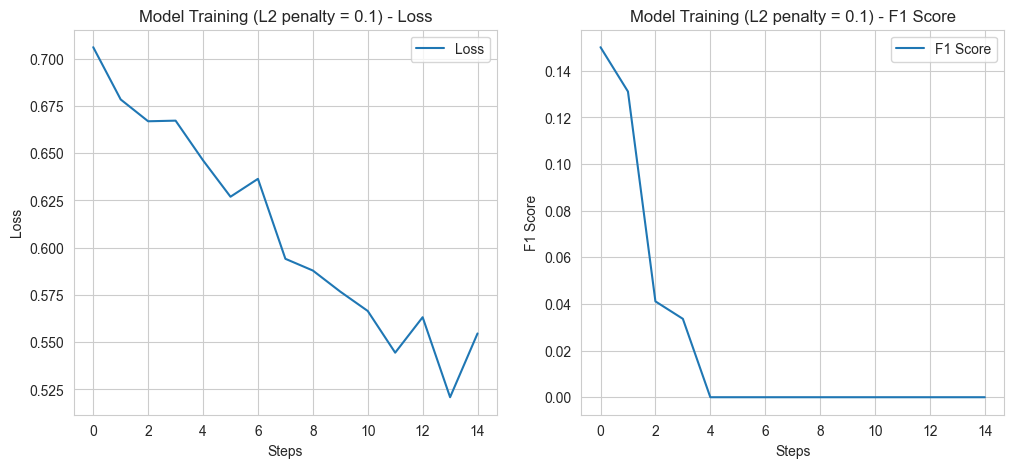

Training with learning rate 0.1


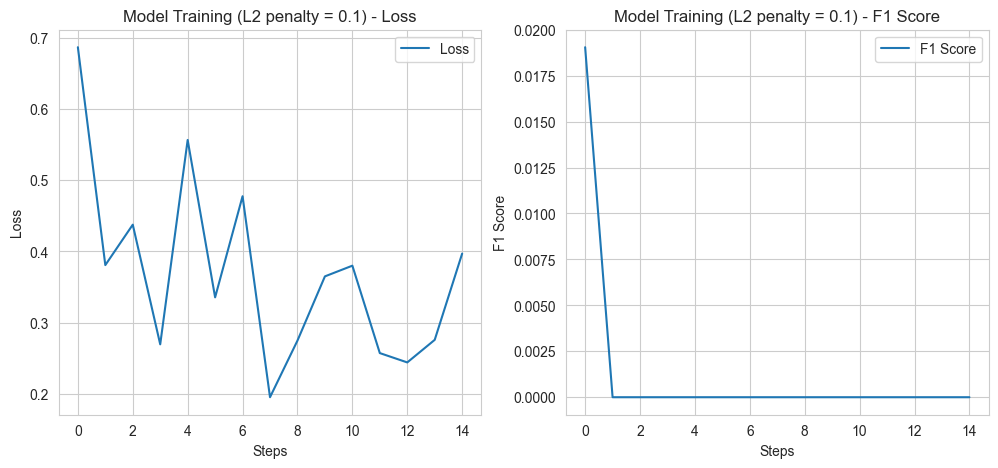

Training with learning rate 1


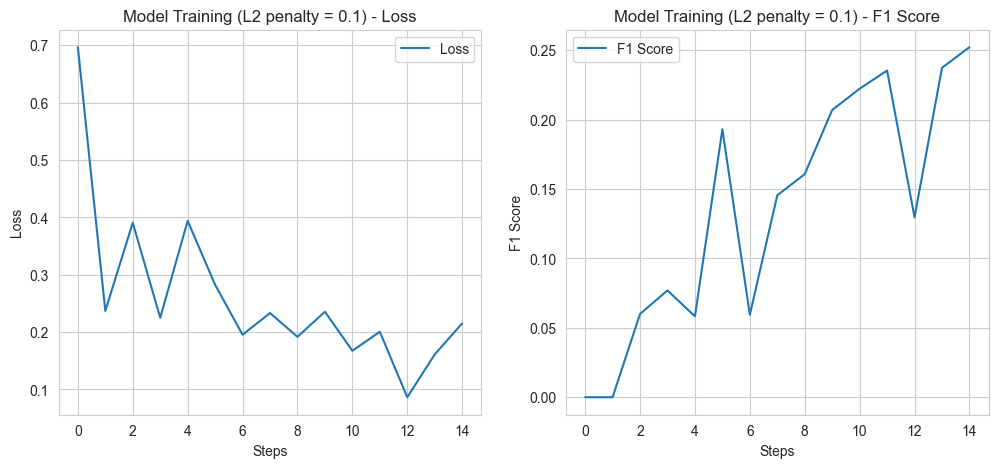

In [86]:
learning_rates = [0.001, 0.1, 1]
for lr in learning_rates:
    model = LogisticRegressionPyTorch(X_train.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    print(f"Training with learning rate {lr}")
    losses, f1_scores = train_model_n_epoch(model, dataloader, criterion, optimizer)
    plot_metrics(losses, f1_scores, f"Model Training (L2 penalty = {l2})")

In [87]:
def train_model_1000_steps2(model, dataloader, criterion, optimizer, X_dev, y_dev, total_steps=10000, report_interval=20):
    model.train()
    step = 0
    losses = []
    f1_scores = []
    best_f1 = 0
    best_model_state = None

    while step < total_steps:
        for inputs, labels in dataloader:
            if step >= total_steps:
                break
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % report_interval == 0:
                losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    dev_outputs = model(X_dev).squeeze()
                    dev_predictions = (dev_outputs >= 0.5).float()
                    f1 = f1_score(y_dev.numpy(), dev_predictions.numpy())
                    f1_scores.append(f1)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_model_state = model.state_dict()  # 保存最佳模型状态
                model.train()
                print(f'Step {step}, Loss: {loss.item()}, F1 Score: {f1:.4f}')
            
            step += 1

    return losses, f1_scores, best_model_state

losses, f1_scores, best_model_state = train_model_1000_steps2(model, dataloader, criterion, optimizer, X_dev, y_dev)
# 加载最佳模型状态
model.load_state_dict(best_model_state)

# 准备测试数据的文档列表
test_document_list = []
print("Creating document list for test...")
for idx, record in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    text_content = str(record["text"])  # 确保文本内容是字符串
    test_document_list.append(better_tokenize(text_content))

# 生成测试数据的CSR矩阵
test_matrix, _ = createCompressedSparseRowMatrix(test_document_list, vocab=training_vocab, frequencyFilter=term_dictionary)

# 添加偏置列
bias_column = np.ones((test_matrix.shape[0], 1))
test_matrix_with_bias = sparse.hstack([test_matrix, bias_column]).tocsr()

# 转换为PyTorch的稀疏张量
X_test = to_sparse_tensor(test_matrix_with_bias)

# 预测函数（确保处理整个测试集）
def make_predictions_pytorch(data, model):
    model.eval()
    predictions = []
    print("Predicting labels for test dataset...")
    with torch.no_grad():
        for inputs in data:
            outputs = model(inputs).squeeze()
            prediction = 1 if outputs.item() >= 0.5 else 0
            predictions.append(prediction)
    return predictions

# 使用最佳模型进行预测
predicted_labels = make_predictions_pytorch(X_test, model)

# 创建包含预测结果的DataFrame
result_df = pd.DataFrame({
    'par_id': df_test['par_id'],
    'label': predicted_labels
})

# 保存结果到CSV文件
result_df.to_csv("part3_result.csv", index=False)

Step 0, Loss: 0.2686435282230377, F1 Score: 0.2787
Step 20, Loss: 0.10579632967710495, F1 Score: 0.2143
Step 40, Loss: 0.1847837120294571, F1 Score: 0.2500
Step 60, Loss: 0.24889323115348816, F1 Score: 0.3231
Step 80, Loss: 0.23638473451137543, F1 Score: 0.2787
Step 100, Loss: 0.3050448000431061, F1 Score: 0.3231
Step 120, Loss: 0.15884946286678314, F1 Score: 0.2787
Step 140, Loss: 0.18458028137683868, F1 Score: 0.2951
Step 160, Loss: 0.20644408464431763, F1 Score: 0.2927
Step 180, Loss: 0.2608337998390198, F1 Score: 0.3016
Step 200, Loss: 0.1792677640914917, F1 Score: 0.2810
Step 220, Loss: 0.12291815131902695, F1 Score: 0.2969
Step 240, Loss: 0.14532525837421417, F1 Score: 0.2880
Step 260, Loss: 0.27184998989105225, F1 Score: 0.2645
Step 280, Loss: 0.07351905107498169, F1 Score: 0.2353
Step 300, Loss: 0.25431644916534424, F1 Score: 0.3308
Step 320, Loss: 0.22974424064159393, F1 Score: 0.2992
Step 340, Loss: 0.14248931407928467, F1 Score: 0.2903
Step 360, Loss: 0.14006935060024261, F1

100%|██████████| 2094/2094 [00:00<00:00, 16355.90it/s]


Constructing compressed sparse row (CSR) matrix...


100%|██████████| 2094/2094 [00:00<00:00, 174408.69it/s]

Predicting labels for test dataset...
